# Exploring Dimlp and Fidex rule generation for breast cancer classification

**Introduction:**

By the end of this notebook, you'll have a solid understanding of how to use Dimlp to train the model and the Fidex algorithms to extract rules.

**Objectives:**

    1. Understand the importance of interpretability in medical problems.
    2. Introduce Dimlp and Fidex as powerful XAI techniques.
    3. Understand how to use Dimlp and Fidex.
    4. Showcase the capabilities of HES-Xplain in implementing Dimlp and Fidex algorithms.
    5. Provide practical insights into applying Dimlp and Fidex to breast cancer classifiers through an interactive notebook.
    6. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

    1. Dataset and Problem Statement.
    2. Load the dataset.
    3. Model training.
    4. Local rules generation - Fidex.
    5. Global ruleSet generation - FidexGlo.
    6. Conclusion.
    7. References.

---
## Google Colab Setup

This section prepares the notebook for use with Google Colaboratory. If applicable, change the following variable to True:


In [1]:
# Colab compatibility
use_colab = False

In [2]:
if use_colab:
    # ensure the directory is empty
    !rm -rf * .config

    !# install codebase from GitHub
    !git clone --no-checkout https://github.com/HES-XPLAIN/notebooks.git --depth=1 .
    !git config core.sparseCheckout true
    !git sparse-checkout set --cone
    !git sparse-checkout add use_case_dimlpfidex
    !git sparse-checkout reapply
    !git checkout main

    # adjust folder structure
    !mv use_case_dimlpfidex/* .
    !rm -rf use_case_dimlpfidex/

# Dataset and Problem Statement

The Breast Cancer Dataset used in this use case consists of 569 data samples representing patients who have tumors. Each patient has 30 attributes, computed out of an image, used to determine if the tumor is malignant (first class) or benign (second class). This dataset is available on [Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) and can be imported with sklearn. It is composed of 455 training samples and 114 testing samples. 

The 30 attributes are composed of 10 real-valued features computed for each cell nucleus :

- **Radius**: Mean of distances from the center to points on the perimeter.
- **Texture**: Standard deviation of gray-scale values.
- **Perimeter**
- **Area**
- **Smoothness**: Local variation in radius lengths.
- **Compactness**: $\frac{\text{perimeter}^2}{\text{area}} - 1.0$
- **Concavity**: Severity of concave portions of the contour.
- **Concave Points**: Number of concave portions of the contour.
- **Symmetry**
- **Fractal Dimension**: "Coastline approximation" - 1.

For each tumor image, the mean, standard error, and worst errors were computed and appear as different attributes.

**Problem Statement:** Our objective is to build a robust classifier capable of accurately classifying breast cancer samples among the 2 classes. By leveraging deep learning techniques and Fidex algorithms, we aim to not only achieve high classification performance but also gain insights into the attributes that contribute to the classification decisions.

# Load the dataset

We'll start by importing all libraries.

In [3]:
import os, sys
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.utils import shuffle
from dimlpfidex.dimlp import dimlpBT
from IPython.display import Image, display
from trainings.normalization import normalization
from trainings.computeRocCurve import computeRocCurve
from dimlpfidex.fidex import fidex, fidexGloRules, fidexGloStats, fidexGlo

class Unbuffered(object):
   def __init__(self, stream):
       self.stream = stream
   def write(self, data):
       self.stream.write(data)
       self.stream.flush()
   def writelines(self, datas):
       self.stream.writelines(datas)
       self.stream.flush()
   def __getattr__(self, attr):
       return getattr(self.stream, attr)


sys.stdout = Unbuffered(sys.stdout)

We download the dataset with sklearn, then shuffle it randomly.

In [4]:
# datas, classes = shuffle(load_breast_cancer().data, load_breast_cancer().target)

dataset, classes = load_breast_cancer(return_X_y=True, as_frame=True)
classesLabels = list(load_breast_cancer().target_names)

# classes one-hot encoding 
classes = pd.get_dummies(classes, dtype="uint8")

# rename classes
classes = classes.rename(
    columns={
        classes.columns[0]: classesLabels[0],
        classes.columns[1]: classesLabels[1],
    }
)

dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We separate the dataset into a training set (75%) and test set (25%).

In [5]:
nbSamples = dataset.shape[0]
nbAttributes = len(dataset.columns)
nbClasses = len(classes.columns)

cutoff = int(0.75 * nbSamples)

trainData = dataset.iloc[:cutoff, :]
testData = dataset.iloc[cutoff:, :]
trainClasses = classes.iloc[:cutoff]
testClasses = classes.iloc[cutoff:]

assert (trainData.shape[0] + testData.shape[0]) == nbSamples
assert (trainClasses.shape[0] + testClasses.shape[0]) == nbSamples

We display the number of training and testing data and check that there is the same number of data as classes.

In [6]:
print(f"There are {trainData.shape[0]} train datas and {trainClasses.shape[0]} train classes")
print(f"There are {testData.shape[0]} test datas and {testClasses.shape[0]} test classes")

There are 426 train datas and 426 train classes
There are 143 test datas and 143 test classes


Now, we save the all the data in text files in a specific format into BCWDataset directory. 

In [7]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")

rootDir = "data/BCWDataset/"
create_folder(rootDir)

# defining filenames
datasetFile = "datas.txt"
trainDataFile = "trainData.txt"
testDataFile = "testData.txt"
trainClassFile = "trainClass.txt"
testClassFile = "testClass.txt"

dataset.to_csv(rootDir+datasetFile, header=False, index=False)
3
testData.to_csv(rootDir+testDataFile, header=False, index=False)
testClasses.to_csv(rootDir+testClassFile, header=False, index=False)
trainData.to_csv(rootDir+trainDataFile, header=False, index=False)
trainClasses.to_csv(rootDir+trainClassFile, header=False, index=False)

Finally, we normalize the data so that the model learns better. We save the mean and std of each attribute in the file normalization_stats.txt. We use the normalization file located in the trainings module. To display the parameters, you can just call normalization with no parameters, or with -h or --help. Without further details, we normalize with this command :

In [8]:
#normalization("--help")

args = f"""
        --data_files [{trainDataFile},{testDataFile}] 
        --nb_attributes {nbAttributes} 
        --missing_values NaN 
        --root_folder {rootDir}
        """
normalization(args)

Parameters list:
 - root_folder                                                   data/BCWDataset/
 - nb_attributes                                                 30
 - data_files                                                    ['data/BCWDataset/trainData.txt', 'data/BCWDataset/testData.txt']
 - missing_values                                                NaN
 - normalization_indices                                         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
 - output_normalization_file                                     data/BCWDataset/normalization_stats.txt
 - output_data_files                                             ['data/BCWDataset/trainData_normalized.txt', 'data/BCWDataset/testData_normalized.txt']
 - with_median                                                   False
 - fill_missing_values                                           True
End of Parameters list. 


Full execution time = 0.306102 

0

To show attribute names:

In [9]:
attributes = list(dataset.columns)
print(attributes)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


And class names:

In [10]:
classes = list(classes.columns)
print(classes)

['malignant', 'benign']


We store attribute and class names in a file named `attributes.txt` to identify features within rules.

In [11]:
attributesFileName = "attributes.txt" 
attributesFileContent = attributes + classesLabels
attributesFileContent = [x.replace(" ", "_") for x in attributesFileContent]

with open(rootDir+attributesFileName, "w") as f:
    for item in attributesFileContent:
        f.write(item+'\n')

# Model training
Here is an example of how to train a DimlpBT model with our dataset.

First, let's display all the DimlpBT parameters available:

To configure our training, we will use this configuration file, located at `data/BCWTemplates/config_dimlpBT.json`:

```json
{
    "root_folder": "data/BCWDataset",
    "train_data_file": "trainData_normalized.txt",
    "train_class_file": "trainClass.txt",
    "test_data_file": "testData_normalized.txt",
    "test_class_file": "testClass.txt",
    "attributes_file": "attributes.txt",
    "train_pred_outfile": "predTrain.out",
    "test_pred_outfile": "predTest.out",
    "console_file": "resultDimlpBT.txt",
    "with_rule_extraction": true,
    "global_rules_outfile": "dimlpBTRules.rls",
    "weights_outfile": "weights.wts",
    "stats_file": "stats.txt",
    "nb_attributes": 30,
    "nb_classes": 2,
    "hidden_layers": [5]
}
```

> A detailed list of parameters is available [here](https://hes-xplain.github.io/documentation/algorithms/dimlp/dimlpbt/). If you want to create your own configuration file, we recommend using our [configuration file creator](https://hes-xplain.github.io/documentation/gui/)



We can start training our model: 

In [12]:
result = dimlpBT("--json_config_file data/BCWTemplates/config_dimlpBT.json")

You can check all outputs inside the `data/BCWDataset` folder.

Inside `stats.txt` you can see the train and test accuracy as well as the sum squared errors. 

There are also the train predictions, test predictions, the weights, and the dimlp rules files.

In the file `dimlpBTRules.txt`, you can see the rule set, some statistics on the rules, and some statistics on the ruleset. Each rule is composed of antecedents and target class as well as the number of covering of the rule, which is the number of examples that verify (or "activate") the rule (even if the class is not correct).

In the `Training set` and `Testing set` sections, each rule is composed, left to right, of:

The number of covered samples, the number of correct covered samples, the number of false covered samples, and the accuracy of the rule.

Between the `Training set` and `Testing set` sections, There are statistics of the ruleset:

- The number of rules in the set.
- The mean total and the mean number of antecedents per rule.
- The covering of the rule.
- The rules' accuracy.
- The fidelity to the model is the percentage of covered samples that are correct concerning the model's decision.
- The model accuracy if we keep only the samples for which the model and the rules decision agree.
- The default rule activation rate, which is the percentage of samples for which no rule is activated.

# Local rules generation - Fidex

Fidex is an algorithm used in classification problems that allows us to obtain a rule explaining the decision class of the model for a given test sample. It enables us to grasp the model's decision-making process and to better understand the importance of each parameter in discerning the nature of the tumor, distinguishing between benign and malignant cases.

Now we can generate some local rules to explain the models' results. We can start with launching Fidex on one test sample. This will generate a rule explaining the sample locally. It is local because the algorithm searches a rule only for one sample.
Fidex is located in the fidex module. Let's take a look at the parameters :

In [13]:
res = fidex("--help")


---------------------------------------------------------------------

Warning! The files are located with respect to the root folder dimlpfidex.
The arguments can be specified in the command or in a json configuration file with --json_config_file your_config_file.json.

----------------------------

Required parameters:

--train_data_file <str>       Path to the file containing the train portion of the dataset
--train_class_file <str>      Path to the file containing the train true classes of the dataset, not mandatory if classes are specified in train data file
--train_pred_file <str>       Path to the file containing predictions on the train portion of the dataset
--test_data_file <str>        Path to the file containing the test sample(s) data, prediction (if no --test_pred_file) and true class(if no --test_class_file)
--test_pred_file <str>        Path to the file containing predictions on the test portion of the dataset
--weights_file <str>          Path to the file containing t

We see that we need the number of attributes and classes, the train and test data and class files, as well as train and test predictions, weights file name, and rule output file name where the rules will be saved.<br>
We specify as well the saved folder and the attributes.<br>
We also need to specify the normalization file obtained from training, to denormalize the values in the generated rule, otherwise the values will be normalized and impossible to interpret.<br>

To see what happens, we launch it with just one sample, and we save beforehand the test data sample in a file with its class and predictions:

In [25]:
testPredsFile = "predTest.out"
testSampleFile = "testDataSample.txt"
testPreds = pd.read_csv(rootDir+testPredsFile, sep=" ", header=None, index_col=None).iloc[:, :nbClasses]
testDatasNormalized = pd.read_csv(rootDir+testDataFile, header=None, index_col=None)

sampleSelected = 0
assert(sampleSelected < nbSamples)

# extract a sample to generate local rule
sampleData = testData.iloc[sampleSelected, :nbAttributes].to_list()
samplePred = testPreds.iloc[sampleSelected, :].to_list()
sampleClasses = testData.iloc[sampleSelected, nbAttributes:].to_list()

# write the sample, classes and predictions in the testSampleFile file (file writing format must be respected)
with open(rootDir+testSampleFile, 'w') as f:
    f.write(" ".join(str(x) for x in sampleData) + '\n')
    f.write(" ".join(str(x) for x in samplePred) + '\n')
    f.write(" ".join(str(x) for x in sampleClasses) + '\n')

#res = fidex.fidex("--train_data_file trainData_normalized.txt --train_pred_file predTrain.out --train_class_file trainClass.txt --test_data_file testDataSample.txt --weights_file weights.wts --attributes_file attributes.txt --rules_outfile rule.rls --nb_attributes 30 --nb_classes 2 --normalization_file normalization_stats.txt --root_folder data/BCWDataset")
res = fidex("--json_config_file data/BCWTemplates/config_fidexOne.json")

Parameters list:
 - train_data_file                                             data/BCWDataset/trainData_normalized.txt
 - train_pred_file                                                        data/BCWDataset/predTrain.out
 - train_class_file                                                      data/BCWDataset/trainClass.txt
 - test_data_file                                                    data/BCWDataset/testDataSample.txt
 - rules_outfile                                                               data/BCWDataset/rule.rls
 - root_folder                                                                          data/BCWDataset
 - attributes_file                                                       data/BCWDataset/attributes.txt
 - weights_file                                                             data/BCWDataset/weights.wts
 - normalization_file                                           data/BCWDataset/normalization_stats.txt
 - nb_attributes                               

You can see the walkthrough of the algorithm and the rule extracted. The rule is also saved in the rule.rls file. With the rule, we see also the covering size of the rule on the training set, the fidelity, the accuracy, and the confidence of the rule. The confidence shows how much the rule is confident with his choices, with respect to the prediction values.<br>

Now, we execute Fidex with all test samples. We send the console output in the fidexResult.txt file and save the global statistics in fidexStats.txt. **It should take about a minute**.

In [27]:
#res = fidex.fidex("--train_data_file trainData_normalized.txt --train_pred_file predTrain.out --train_class_file trainClass.txt --test_data_file testData_normalized.txt --test_class_file testClass.txt --test_pred_file predTest.out --weights_file weights.wts --attributes_file attributes.txt --rules_outfile fidexRules.rls --stats_file fidexStats.txt --console_file fidexResult.txt --nb_attributes 30 --nb_classes 2 --normalization_file normalization_stats.txt --root_folder data/BCWDataset")
res = fidex("--json_config_file data/BCWTemplates/config_fidex.json")

if (res == 0):
    print("Fidex done")

Fidex done


You can see the rules generated for each sample in the file fidexRules.rls. The global statistics on the test set appear in statsFidex.txt. There is the mean covering size per rule, the mean number of antecedents per rule, and the mean rule fidelity, accuracy, and confidence.

# Global ruleSet generation - FidexGlo
We've seen how to compute a rule that explains the decision of the model for a specific sample. Now, we will generalize a ruleset that characterizes the whole train dataset. That means that for each training sample, there is a rule in the set of rules that explains the model's decision for this sample. We will use this global ruleset to explain the results obtained on new test samples. If there is a rule of the ruleset corresponding to the sample, we take this one and get a global explanation for the sample. If there is none, we call Fidex and only have a local explanation.<br>

To get the ruleSet we execute fidexGloRules which is located in the fidex module. Here are the possible parameters :

In [28]:
res = fidexGloRules("--help")


---------------------------------------------------------------------

Warning! The files are located with respect to the root folder dimlpfidex.
The arguments can be specified in the command or in a json configuration file with --json_config_file your_config_file.json.

----------------------------

Required parameters:

--train_data_file <str>       Path to the file containing the train portion of the dataset
--train_class_file <str>      Path to the file containing the train true classes of the dataset, not mandatory if classes are specified in train data file
--train_pred_file <str>       Path to the file containing predictions on the train portion of the dataset
--weights_file <str>          Path to the file containing the trained weights of the model (not mandatory if a rules file is given with --rules_file)
--rules_file <str>            Path to the file containing the trained rules to be converted to hyperlocus (not mandatory if a weights file is given with --weights_file)
--gl

We use nearly the same parameters as for Fidex but we only need train data. We need to choose a heuristic for fidexGloRules, we choose the optimal to get better results. We don't forget to add the normalization file.<br>
**It should take about 3 minutes**. If you have several processors available, you should add the parameter nb_threads with the number of processors that you want to use, it can speed up the process a lot. If you want to accelerate the process even more, you can use some dropout, the algorithm will randomly skip some dimensions or some hyperplans. For example, you can put: -d 0.5 -h 0.5, to skip half dimensions and half hyperplans, which should be about 4 times faster.

In [30]:
#res = fidex.fidexGloRules("--train_data_file trainData_normalized.txt --train_pred_file predTrain.out --train_class_file trainClass.txt --weights_file weights.wts --attributes_file attributes.txt --nb_attributes 30 --nb_classes 2 --heuristic 1 --global_rules_outfile globalRules.rls --console_file fidexGloRulesResult.txt --normalization_file normalization_stats.txt --root_folder data/BCWDataset")
res = fidexGloRules("--json_config_file data/BCWTemplates/config_fidexGloRules.json")
if (res == 0):
    print("FidexGloRules done")

FidexGloRules done


You can see the console result in the file fidexGloRulesResult.txt and the ruleset in the file globalRules.rls.
The algorithm is random, so each execution may generate different rules and a different number of them. It should generate about 25 rules. You can see at the top of the globalRules file the number of rules, the mean covering number per rule, and the mean number of antecedents. Here is an example of a rule that you may obtain:<br>

Rule 1: WORST_CONCAVE_POINTS<0.111377 AREA_ERROR<37.691316 -> BENIGN <br>
   Train Covering size : 217 <br>
   Train Fidelity : 1 <br>
   Train Accuracy : 0.990783 <br>
   Train Confidence : 0.984811 <br>

This rule is the first rule, which means that it's the rule with the maximum covering. Here, 217 train samples verify this rule. She is 100% fidel with the model and has about 99% train accuracy.
This rule says that if you have worst concave points lower than 0.111377 and an area error lower than 37.691316, then your breast cancer is benign. And this rule is accurate, on train test, at 99% and has 98% of confidence.<br>

Now, we can see some global statistics on the test set, and also some statistics directly on each rule. So we will see the test accuracy on this rule.<br>
We execute fidexGloStats which is located in the fidex module. First, let's check the parameters :

In [31]:
res = fidexGloStats("--help")


---------------------------------------------------------------------

Warning! The files are located with respect to the root folder dimlpfidex.
The arguments can be specified in the command or in a json configuration file with --json_config_file your_config_file.json.

----------------------------

Required parameters:

--test_data_file <str>        Path to the file containing the test portion of the dataset
--test_class_file <str>       Path to the file containing the test true classes of the dataset, not mandatory if classes are specified in test data file
--test_pred_file <str>        Path to the file containing predictions on the test portion of the dataset
--global_rules_file <str>     Path to the file containing the global rules obtained with fidexGloRules algorithm.
--nb_attributes <int [1,inf[> Number of attributes in the dataset
--nb_classes <int [2,inf[>    Number of classes in the dataset

----------------------------

Optional parameters: 

-h --help                     

We need the test files(data, prediction, class), the rules file, and the number of attributes and classes. We need to specify the attribute file as well. We choose to save the results in the file fidexGloStats.txt. With --global_rules_outfile we can generate the statistics on rules which will modify the rules file. If you want to keep the first ruleSet unchanged, you should give another name. Finally, with --positive_class_index we can specify the positive class in order to get a ROC curve and some other statistics on false and true positives/negatives. We will design the malignant class as positive. So here is the command :

In [32]:
#res = fidex.fidexGloStats("--test_data_file testData.txt --test_pred_file predTest.out --test_class_file testClass.txt --attributes_file attributes.txt --global_rules_file globalRules.rls --global_rules_outfile globalRules.rls --nb_attributes 30 --nb_classes 2 --stats_file fidexGloStats.txt --positive_class_index 0 --root_folder data/BCWDataset")
res = fidexGloStats("--json_config_file data/BCWTemplates/config_fidexGloStats.json")

Parameters list:
 - test_data_file                                                          data/BCWDataset/testData.txt
 - test_pred_file                                                          data/BCWDataset/predTest.out
 - test_class_file                                                        data/BCWDataset/testClass.txt
 - global_rules_outfile                                                 data/BCWDataset/globalRules.rls
 - global_rules_file                                                    data/BCWDataset/globalRules.rls
 - root_folder                                                                          data/BCWDataset
 - attributes_file                                                       data/BCWDataset/attributes.txt
 - stats_file                                                         data/BCWDataset/fidexGloStats.txt
 - nb_attributes                                                                                     30
 - nb_classes                                  

Here you can see the global statistics on the test set. As the previous calculations have randomness, each execution is a bit different. So here we will discuss the same case as before, so you may have slightly different results. In our case, we had about 98% fidelity, which is good, and a rule accuracy(96.5%) about 1.5% lower than the model accuracy(98%). So the rules seem to classify a bit worse. The explainability rate is the percentage of samples for which we can find a rule in the rules set. For the others, we need to execute Fidex (this is the default rule rate). In our case, we had more than a 97% explainability rate, so only in 3% of cases do we need to compute Fidex. Each rule can activate many rules. Here on average, a sample activates 5 correct rules and 0.05 wrong rules. A wrong rule is a rule with which the model doesn't agree. For example, if the rule says malign and the model says benign. Something interesting is the model test accuracy when rules and model agree. You can see that, generally, the accuracy increases if we consider samples where rules and model agree, and increases even more if we take only the activated rules (when there are no activated rules, we choose the model prediction). That means that the rules confirm well the model decision, but when no rule is found, the model decision may as well be wrong. <br>

Finally, we have the statistics on the positive/negative decisions of the model and of the rules. For the model's decisions, we had 1% false positives and 7% false negatives. That means that when the model says that it's malign, it has a 99% chance of being malign. But when it says that it's benign, there is a 7% risk that it is malign in reality. So the precision is 97% and the recall is 93%.

In the case of the rules decisions, the rules decision is the same as the model if we find a correct rule. If there is no rule, we can launch Fidex, so it's also the same decision as the model because it will create a fidel rule. The only scenario when the decision changes from the model's is when some rules are activated, all rules decide the same class which is not the class chosen by the model. The results are really close with 95% of precision and 93% of recall.

In globalRules file, you can now see the statistics of rules on the test set. Here is the same rule as before that I have now:<br>

Rule 1: MEAN_CONCAVE_POINTS<0.041282 WORST_CONCAVE_POINTS<0.150829 -> BENIGN <br>
   Train Covering size : 217 --- Test Covering size : 54 <br>
   Train Fidelity : 1 --- Test Fidelity : 0.981481 <br>
   Train Accuracy : 0.990783 --- Test Accuracy : 1 <br>
   Train Confidence : 0.984811 --- Test Confidence : 0.979816 <br>

You can see that the rule no longer always agrees with the model, only in 98.15% of cases. However, the rule accuracy has increased with the test. That means that the rule is very good in reality, with 100% of correct classification.

We can get a ROC curve obtained with the test set. Here are the parameters of computeRocCurve which is located in the trainings package :

In [33]:
res = computeRocCurve("--help")

Usage: 
--test_class_file <str> --test_pred_file <str> --positive_class_index <int [0,nb_classes-1]> --nb_classes <int [1,inf[> [-h, --help] [--json_config_file <str>] [--root_folder <str>] [--stats_file <str>] [--show_params <bool>] [--output_roc <str>] [--estimator <str>]

This is a parser for computeRocCurve


Parameters:

  ---------------------------------------------------------------------

  Warning! The files are located with respect to the root folder dimlpfidex.

  The arguments can be specified in the command or in a json configuration file with --json_config_file your_config_file.json.

  ----------------------------

  Required parameters:

  --test_class_file <str>                        Path to the file containing the test true classes of the dataset
  --test_pred_file <str>                         Test prediction file
  --positive_class_index <int [0,nb_classes-1]>  Index of the positive class, index starts at 0
  --nb_classes <int [1,inf[>                     Number o

We execute computeRocCurve :

In [34]:
#res = computeRocCurve('--test_class_file testClass.txt --test_pred_file predTest.out --positive_class_index 0 --output_roc outRoc.png --stats_file stats.txt --root_folder data/BCWDataset --nb_classes 2 --show_params false')
res = computeRocCurve("--json_config_file data/BCWTemplates/config_roc.json")

The AUC score is added to the stats file and the ROC curve is saved in the outRoc.png file. We get an AUC of about 99%. <br>
We can visualize the AUC curve :

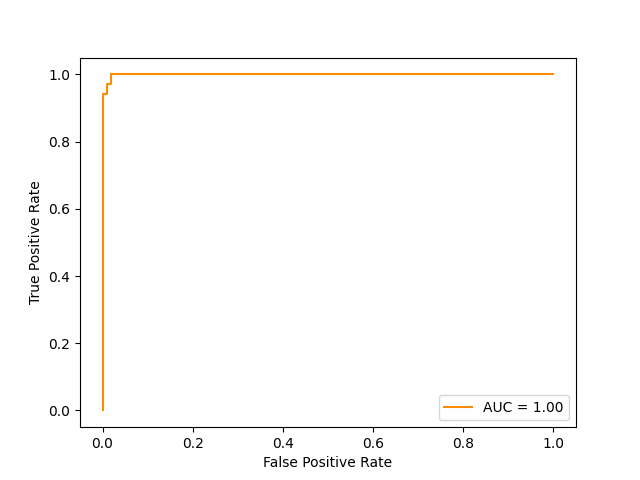

In [35]:
display(Image(filename="data/BCWDataset/outRoc.png"))

Finally, it's possible to launch fidexGlo on a test set. It will, for each test sample, search in the global ruleset for all the rules that verify the sample's properties and match the decision of the model. If no rule verifies the properties, it calls Fidex on the test sample. In the other case, it gives all the correct and wrong activated rules.<br>

FidexGlo is located in the fidex module. Here are the possible parameters:

In [36]:
res = fidexGlo("--help")


---------------------------------------------------------------------

Warning! The files are located with respect to the root folder dimlpfidex.
The arguments can be specified in the command or in a JSON configuration file with --json_config_file your_config_file.json.

----------------------------

Required parameters:

--test_data_file <str>        Path to the file containing test sample(s) data, prediction (if no --test_pred_file) and true classes if launching with fidex (--with_fidex and if no --test_class_file)
--test_pred_file <str>        Path to the file containing predictions on the test portion of the dataset. If given, --test_data_file needs to have only the test data
--global_rules_file <str>     Path to the file containing the global rules obtained with fidexGloRules algorithm.
--nb_attributes <int [1,inf[> Number of attributes in the dataset
--nb_classes <int [2,inf[>    Number of classes in the dataset

----------------------------

Optional parameters: 

-h --help    

As we want to use Fidex on test sample not covered by the global ruleset, we need to specify the Fidex parameters. We don't forget to add the normalization file and launch it with :

In [37]:
#res = fidex.fidexGlo("--test_data_file testData.txt --test_pred_file predTest.out --global_rules_file globalRules.rls --nb_attributes 30 --nb_classes 2 --attributes_file attributes.txt --explanation_file explanations.txt --console_file fidexGloResults.txt --root_folder data/BCWDataset --with_fidex true --train_data_file trainData.txt --train_pred_file predTrain.out --train_class_file trainClass.txt --test_class_file testClass.txt --weights_file weights.wts --normalization_file normalization_stats.txt")
res = fidexGlo("--json_config_file data/BCWTemplates/config_fidexGlo.json")

if res == 0:
    print("Explanations generated") 

Explanations generated


The explanations for each test sample can then be found in the file explanations.txt. We do not find a global rule for around 2.6% of the samples, for which we calculate a local rule using Fidex.

# Conclusion

Throughout this notebook, we've learned how to use DimlpBT to train a dataset and get some explaining rules, and we got into the different Fidex algorithms to get some local and global explanations, and some statistics on the model's decisions. We used the example of the breast cancer dataset from Wisconsin and we saw that the algorithms perform very well. It gives some good explanations of the model's decision and does it very fast, especially if a fidexGlo ruleset has been computed beforehand. You can try with any tabular dataset you want, you just have to remember to transform the data in a good format. <be>

We didn't speak about every single parameter, you can try to change every hyperparameter you want to see how it goes. An interesting parameter that we didn't consider is the parameter for decision threshold (--decision_threshold) in Fidex algorithms. It allows us to change predictions with respect to a specific threshold on the positive class. If the model gives a score prediction, for the positive class, greater than this threshold, the model prediction is considered to be the positive class, even if another class obtains a higher score. If the recall is not good enough, it's possible to improve it this way. Another parameter is the seed. It allows you to remove the randomness of the algorithms and get the same result in each execution for the same parameters and data.<br>

We considered only a simple tabular dataset. It's also possible to use it for an image classification problem. To see how we can train a dataset with convolutions, we recommend exploring the [`Mnist notebook`](mnist.ipynb) for a hands-on experience. There are also other training methods, like an MLP or decision trees. The [`Obesity CVD`](obesityCvdRisk.ipynb) notebook goes through these and shows what to do when we have categorical attributes.

# References

HES-XPLAIN: [website](https://hes-xplain.github.io/), [Github page](https://github.com/HES-XPLAIN)

Dataset: [source](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

Dimlpfidex: [Github repository](https://github.com/HES-XPLAIN/dimlpfidex), [documentation](https://hes-xplain.github.io/documentation/overview/)

Algorithms: [randomForest](https://hes-xplain.github.io/documentation/dimlpfidex/training-methods/randforeststrn/), [Fidex](https://hes-xplain.github.io/documentation/dimlpfidex/fidex/fidex/), [FidexGloRules](https://hes-xplain.github.io/documentation/dimlpfidex/fidex/fidexglorules), [FidexGloStats](https://hes-xplain.github.io/documentation/dimlpfidex/fidex/fidexglostats)